In [1]:
from keras_vggface.vggface import VGGFace
from keras import backend as K
K.set_image_dim_ordering('th')

from keras.engine import Model
from keras.layers import Input

# vgg_model_new = VGGFace(model='vgg16')
# vgg_model_new.summary()

layer_name = 'fc7' 
vgg_model = VGGFace() 
out = vgg_model.get_layer(layer_name).output
vgg_model_new = Model(vgg_model.input, out)
vgg_model_new.summary()

E:\ML\Anaconda3\envs\TF\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 224, 224)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 224, 224)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 112, 112)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 128, 112, 112)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 128, 112, 112)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 128, 56, 56)       0         
__________

E:\ML\Anaconda3\envs\TF\lib\site-packages\keras_vggface\models.py:130: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [2]:
def get_image_features(image_file_name):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    image_features = np.zeros((1, 4096))

    im = cv2.resize(cv2.imread(image_file_name), (224, 224))


    # The mean pixel values are taken from the VGG authors, which are the values computed from the training dataset.
    mean_pixel = [93.5940, 104.7624, 129.1863]

    im = im.astype(np.float32, copy=False) # shape of im = (224,224,3)
    
    for c in range(3):
        im[:, :, c] = im[:, :, c] - mean_pixel[c]        

    im = im.transpose((2,0,1)) # convert the image to RGBA  # shame of im= (3,224,224)

    
    # this axis dimension is required becuase VGG was trained on a dimension
    # of 1, 3, 224, 224 (first axis is for the batch size
    # even though we are using only one image, we have to keep the dimensions consistent
    im = np.expand_dims(im, axis=0)  # shape of im = (1,3,224,224)

    image_features[0,:] = vgg_model_new.predict(im)[0]
    return image_features

In [3]:
import os
import cv2, spacy, numpy as np
import pickle

PATH=os.getcwd()
data_path = PATH + '/dataset'
data_dir_list = os.listdir(data_path)

image_features_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Extracting Features of dataset- '+'{}\n'.format(dataset))
    for img in img_list:
        image_features=get_image_features(data_path + '/'+ dataset + '/'+ img )
        image_features_list.append(image_features)
    
    
image_features_arr=np.asarray(image_features_list)
image_features_arr = np.rollaxis(image_features_arr,1,0)
image_features_arr = image_features_arr[0,:,:]

#np.savetxt('feature_vectors1.txt',image_features_arr)
#feature_vectors = np.loadtxt('feature_vectors.txt')
pickle.dump(image_features_arr, open('feature_vectors1.pkl', 'wb'))


Extracting Features of dataset- pair 1



In [4]:
image_features_arr.shape

(6, 4096)

In [5]:
pickle_in = open("feature_vectors1.pkl","rb")
X = pickle.load(pickle_in)

In [6]:
from sklearn.manifold import TSNE
from glob import glob
import matplotlib
import pickle
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded = TSNE(n_components=2, perplexity = 2.0, 
                 early_exaggeration=12.0, learning_rate=10.0, 
                 n_iter=1000, n_iter_without_progress=300, 
                 min_grad_norm=1e-07, metric='euclidean', 
                 init='random', verbose=0, 
                 random_state=None, method='barnes_hut', angle=0.3).fit_transform(X)
X_embedded.shape

(6, 2)

In [7]:
def visualize_scatter(data_2d, label_ids, figsize=(12,12)):
    plt.figure(figsize=figsize)
    plt.grid()
 
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
#         plt.figure(figsize=figsize)
#         plt.grid()
        plt.title(" data ")
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',                    
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=1,
                    label=id_to_label_dict[label_id]) 
        
    
        
#        plt.title(id_to_label_dict[label_id])
        plt.legend(loc='best')  
#     plt.savefig('pair 4 .png')

In [9]:
images = []
labels = []

PATH=os.getcwd()
DATA_FOLDER = PATH + '/dataset'

for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        images.append(image)
        labels.append(class_folder_name)
        
images = np.array(images)
labels = np.array(labels) 

In [10]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [11]:
label_ids = np.array([label_to_id_dict[x] for x in labels])
label_ids.shape 

(6,)

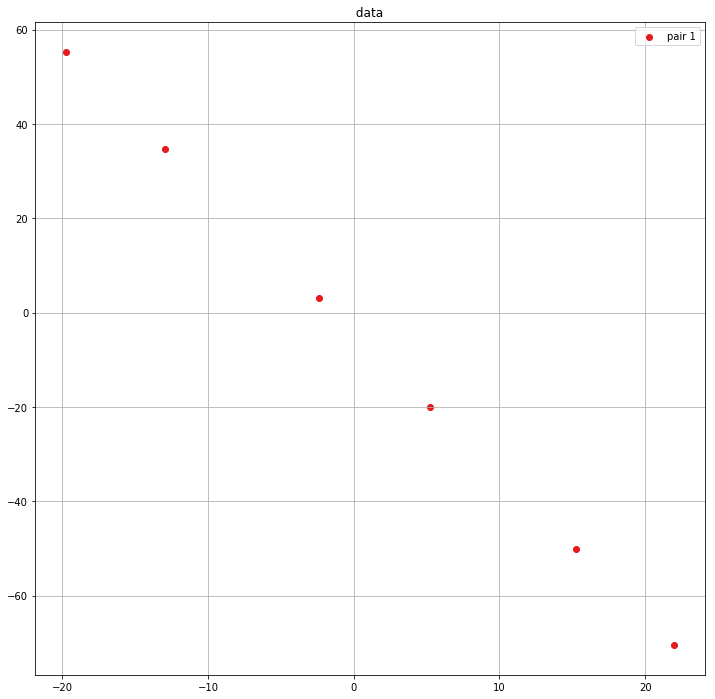

In [12]:
visualize_scatter(X_embedded, label_ids)